In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
from tqdm import tqdm
import scipy as sp
from copy import deepcopy 

# LISA tools
from lisatools.utils.constants import *
from lisatools.sensitivity  import AE1SensitivityMatrix

# BBHX: Suppress the print statements from the BBHX module like: "No CuPy or GPU PhenomHM module"
# This is done to avoid cluttering the output when running sp.optimize.differential_evolution
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

with suppress_stdout():
    from bbhx.waveformbuild import BBHWaveformFD

# My modules
from tools.LISASimulator import LISASimulator
from tools.time_freq_likelihood import TimeFreqLikelihood
from tools.likelihood import get_dh, get_hh, TimeFreqSNR
import tools.likelihood as likelihood
from tools.MBHB_differential_evolution import MBHB_finder

In [2]:
from multiprocessing import cpu_count
print(cpu_count())

11


In [3]:
Tobs = YRSID_SI/12
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

m1 = 3e5
m2 = 1.5e5
a1 = 0.2
a2 = 0.4
dist = 4 * PC_SI * 1e9  # distance in Gpc
phi_ref = np.pi/2
f_ref = 0.0
inc = np.pi/3
lam = np.pi/1.
beta = np.pi/4.
psi = np.pi/4.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(length=1024, direct=False, fill=True, squeeze=False, modes=modes)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, waveform_kwargs=waveform_kwargs)
waveform_kwargs.update(freqs=f_array)

print(sim.SNR_optimal()[0])

3595.48440646233


(2498343.5229473603, 2499353.5229473603)

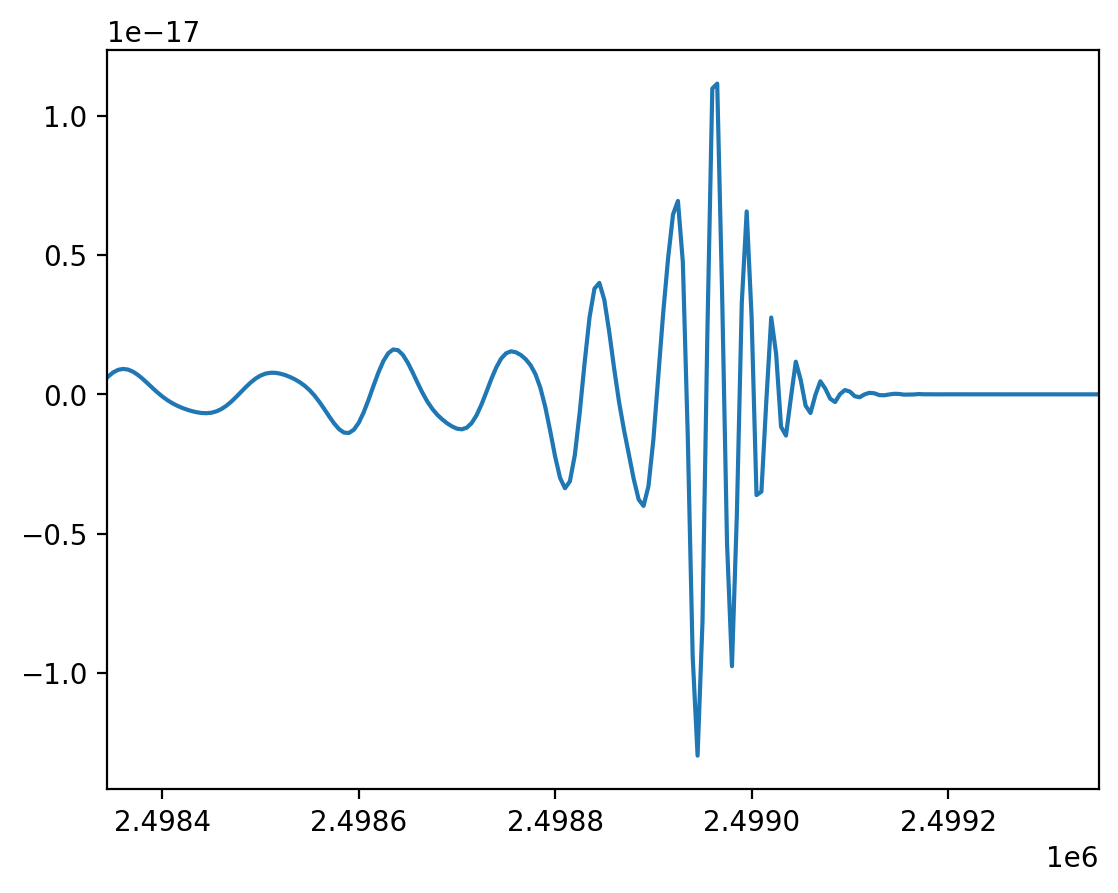

In [4]:
plt.plot(sim.time, sim.signal_t[0,1])
plt.xlim(t_ref - 10, t_ref + 1000)

## Pre-Merger

In [5]:
# Not doing the premerger now to see if the code works better with the merger included
time_before_merger = 60*60
cutoff_time = t_ref - time_before_merger
max_time = t_ref + 60*60*12

def pre_merger(gravitational_wave_data_t, time_before_merger, t_ref, t_array):
        cutoff_time = t_ref - time_before_merger
        cutoff_index = np.searchsorted(t_array, cutoff_time)
        data_t_truncated = gravitational_wave_data_t[:, :cutoff_index]
        return data_t_truncated, cutoff_index

data_t_truncated, cutoff_index =  pre_merger(sim.signal_t[0], time_before_merger, t_ref, t_array)


In [6]:
sim.signal_f[0], data_f

(array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.30502768e-19+7.17069036e-20j, -2.41356935e-19-2.66031081e-21j,
         -2.28814546e-19-7.67528748e-20j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
          8.48183418e-20+8.13380963e-20j,  5.56861685e-20+1.03469497e-19j,
          2.11634874e-20+1.15567492e-19j]], shape=(2, 262985)),
 array([[ 6.92813301e-17+0.00000000e+00j, -1.92850045e-17-5.16325276e-17j,
          4.51696347e-17-6.29358611e-17j, ...,
         -8.85105567e-18+1.68978833e-18j, -1.44005694e-18+1.76941340e-17j,
          1.60415064e-17+0.00000000e+00j],
        [ 1.92504752e-16+0.00000000e+00j, -1.09794323e-16-4.19465371e-17j,
         -5.05217431e-17+1.67868165e-17j, ...,
         -1.48804594e-17+3.87272187e-17j,  2.32320672e-17+2.92333609e-17j,
         -1.58517853e-17+0.00000000e+00j]], shape=(2, 262985))

# The SNR does not depend on the distance. 
Change the guess_distance to see that the SNR is the same. The distance is calculated based on the amplitude.
- This only works when all the other parameters in template are set to the real values. 
- The hope is to use differential_evolution to calculate the remaining parameters reasonably well and get an estimate of distance from that

In [7]:
guess_distance = dist * 1000
signal_with_which_to_test_this = sim.signal_f[0] #data_f
template = wave_gen(
    m1,
    m2,
    a1,
    a2,
    guess_distance, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    **waveform_kwargs
)
template = template[0, :2]
print(likelihood.template_snr(signal_with_which_to_test_this, template, AE1SensitivityMatrix(f_array), df=sim.df))

hh = get_hh(template, AE1SensitivityMatrix(f_array), df=sim.df)
dh = get_dh(signal_with_which_to_test_this, template, AE1SensitivityMatrix(f_array), df=sim.df)
amplitude = dh/hh
new_distance = guess_distance /  amplitude

print( "Percentage diff     = ", (new_distance-dist)*100/dist , "%" )
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = " , dh/np.sqrt(hh))

3595.484406462329
Percentage diff     =  4.1757123185153e-14 %
True distance       =  4.0 Gpc
Dist from Amplitude =  4.000000000000002 Gpc
SNR calculated      =  3595.484406462329


The SNR also does not change with the time-frequency SNR with pre-merger. Change guess_distance and see that nothing changes.
- Again, this only works when all the other parameters in template are set to the real values. 
- The hope is to use differential_evolution to calculate the remaining parameters reasonably well and get an estimate of distance from that.
- But it's good that using time-freq SNR also works to get the distance.
- Change the value of, say, m1 drastically and see that the distance estimate from the equation is awful, which makes sense.

In [8]:
guess_distance = dist 
parameters_new = [
    m1*(1),  # Slightly change m1 to see the effect
    m2,
    a1*(1),  # Slightly change a1 to see the effect
    a2,
    guess_distance,
    phi_ref,
    f_ref,
    inc*(1 ),
    lam,
    beta,
    psi,
    t_ref
]
analysis = TimeFreqSNR(
    data_t_truncated,
    wave_gen=wave_gen,
    nperseg=5000,
    dt_full=dt,
    cutoff_index=cutoff_index,
    pre_merger=True
)
analysis.get_stft_of_data()
SNR, amplitude = analysis.calculate_time_frequency_SNR(*parameters_new, waveform_kwargs=waveform_kwargs)
new_distance = guess_distance /  amplitude
print((new_distance - dist)/(PC_SI*1e9) , (new_distance-dist)/dist)
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = ",  SNR)

0.0 0.0
True distance       =  4.0 Gpc
Dist from Amplitude =  4.0 Gpc
SNR calculated      =  0.7273685958383449


# Differential Evolution Analysis

In [9]:
boundaries = {}
boundaries['Total_Mass'] = [1e5, 6e5]
boundaries['Mass_Ratio'] = [0.05, 0.999999]
boundaries['Spin1'] = [-1, 1]
boundaries['Spin2'] = [-1, 1]
boundaries['Distance'] = [1e3, 10e3] # in Mpc i.e. dL / (PC_SI * 1e6)
boundaries['Phase'] = [0.0, 2 * np.pi]
boundaries['cos(Inclination)'] = [-1, 1]
boundaries['Ecliptic_Longitude'] = [0, 2*np.pi]
boundaries['sin(Ecliptic_Latitude)'] = [-1, 1]
boundaries['Polarization'] = [0, np.pi]
boundaries['Coalescence_Time'] = [cutoff_time, max_time]  

In [33]:
list(boundaries.items())[4][1][0]

list(boundaries.items())[4][0] 



'Distance'

In [10]:
DifferentialEvolution = MBHB_finder(
    data_t = sim.signal_t[0],
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=False,
    #cutoff_index=cutoff_index,
)
DifferentialEvolution.get_stft_of_data()

In [11]:
differential_evolution_kwargs = {
    'strategy': 'best1exp',
    'popsize': 3,
    'tol': 1e-4,
    'maxiter': 30,
    'recombination': 1,
    'mutation': (0.7, 1),
    'polish': False,
    'disp': True,
    'workers': -1,  # Use all available CPU cores
    'updating': 'deferred',
}

fixed_parameters = {
    'Total_Mass': m1 + m2,
    'Mass_Ratio': m2 / m1,
    'Spin1': a1,
    'Spin2': a2,
    'Distance': boundaries['Distance'][0] + 0.5 * (boundaries['Distance'][1] - boundaries['Distance'][0]), # Always include this in fixed parameters
    'Phase': phi_ref,
    'cos(Inclination)': np.cos(inc),
    #'Ecliptic_Longitude': lam,
    'sin(Ecliptic_Latitude)': np.sin(beta),
    'Polarization': psi,
    'Coalescence_Time': t_ref,
}
parameter_names = list(boundaries.keys())

free_param_names = [name for name in parameter_names if name not in fixed_parameters]
bounds = np.array([boundaries[name] for name in free_param_names])
parameters_10 = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])

In [12]:
parameters_11 = []
free_idx = 0
for name in parameter_names:
    if name in fixed_parameters:
        parameters_11.append(fixed_parameters[name])
    else:
        parameters_11.append(parameters_10[free_idx])
        free_idx += 1
parameters_11 = np.array(parameters_11)
parameters_11

array([4.50000000e+05, 5.00000000e-01, 2.00000000e-01, 4.00000000e-01,
       5.50000000e+03, 1.57079633e+00, 5.00000000e-01, 2.24302336e+00,
       7.07106781e-01, 7.85398163e-01, 2.49835352e+06])

In [13]:
found_parameters, found_snr_found, function_evaluations, results = DifferentialEvolution.find_MBHB(differential_evolution_kwargs, fixed_parameters=fixed_parameters)
# The number of messages like "No CuPy or GPU PhenomHM module" you see is exactly equal to the number of workers used. On this macbook, it has 11 cores, so there are 11 messages. Imma just live with this

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.


In [14]:
found_parameters

array([4.50000000e+05, 5.00000000e-01, 2.00000000e-01, 4.00000000e-01,
       4.00551842e+03, 1.57079633e+00, 5.00000000e-01, 3.13796493e+00,
       7.07106781e-01, 7.85398163e-01, 2.49835352e+06])

In [15]:
def transform_parameters(x):
    all_parameters = np.zeros(11)
    all_parameters[0] = x[0] + x[1]
    all_parameters[1] = x[1] / x[0]
    all_parameters[2] = x[2]
    all_parameters[3] = x[3]
    all_parameters[4] = x[4] / (PC_SI * 1e6)
    all_parameters[5] = x[5]
    all_parameters[6] = np.cos(x[7])
    all_parameters[7] = x[8]
    all_parameters[8] = np.sin(x[9])
    all_parameters[9] = x[10]
    all_parameters[10] = x[11]
    return all_parameters

The reason why the distance estimate is so bad (as well as sometimes outside the priors) is because it is calculated from the amplitude that is calculated with a template generated by the other found parameters, which aren't close to the true parameters.


In [20]:
print(f"{'Index':<5} {'Parameter':<25} {'Lower Bound':<15} {'Found':<20} {'True':<20} {'Upper Bound':<15}")
print('-' * 100)

for i, (param, bounds) in enumerate(boundaries.items()):
    lower, upper = bounds
    found = found_parameters[i]
    true = transform_parameters(parameters)[i]
    print(f"{i:<5} {param:<25} {lower:<15.6g} {found:<20.6g} {true:<20.6g} {upper:<15.6g}")

Index Parameter                 Lower Bound     Found                True                 Upper Bound    
----------------------------------------------------------------------------------------------------
0     Total_Mass                100000          450000               450000               600000         
1     Mass_Ratio                0.05            0.5                  0.5                  0.999999       
2     Spin1                     -1              0.2                  0.2                  1              
3     Spin2                     -1              0.4                  0.4                  1              
4     Distance                  1000            4005.52              4000                 10000          
5     Phase                     0               1.5708               1.5708               6.28319        
6     cos(Inclination)          -1              0.5                  0.5                  1              
7     Ecliptic_Longitude        0               3.1

Next Steps:
- no noise
- include merger
- check for only one parameter
- tolerance smaller
- iterations bigger
- check what the variable results contain
- see the Activity Monitor on the macbook. Set nworkers = 1, then 2 and see if it is actually using all the cores